In [1]:
"""Use Perona-Malik regularistion to deblur image"""

'Use Perona-Malik regularistion to deblur image'

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.sparse as sp

from deblurring.blurring import blur_and_noise
from deblurring.solvers import LSQRSolver
from common.operators import derivative_operator, dx_operator, dy_operator, identity_operator, laplacian_operator, perona_malik_operator
from evaluation.tuning import StandardTuner, IterativeTuner

[INFO] 2024-11-24 21:23:08 | Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16. | numexpr.utils-_init_num_threads:148
[INFO] 2024-11-24 21:23:08 | NumExpr defaulting to 16 threads. | numexpr.utils-_init_num_threads:161


Estimated noise variance 2.5720193662202578e-05 vs. actual 2.5899715383858184e-05


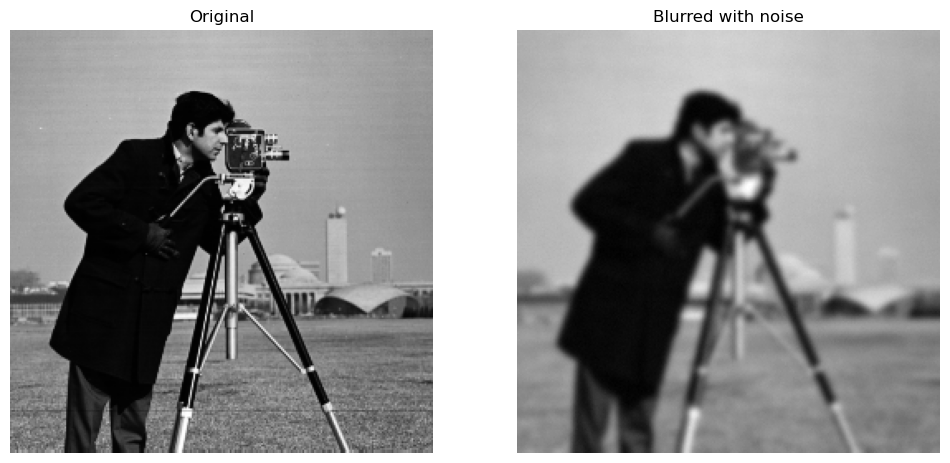

In [3]:
"""Read image and blur with added noise"""

f = plt.imread("../../data/Cameraman256.png").astype("float32")
f = (f - f.min()) / (f.max() - f.min())

theta = 0.02 * np.std(f)  # 2% noise
sigma = 2.0
kernel = partial(gaussian_filter, sigma=sigma)
g = blur_and_noise(f, kernel, theta)
noise_variance = np.var(blur_and_noise(np.zeros_like(g), kernel, theta))
print(f"Estimated noise variance {noise_variance} vs. actual {np.square(theta)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f, cmap="gray")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(g, cmap="gray")
plt.axis("off")
plt.title("Blurred with noise")
plt.show()

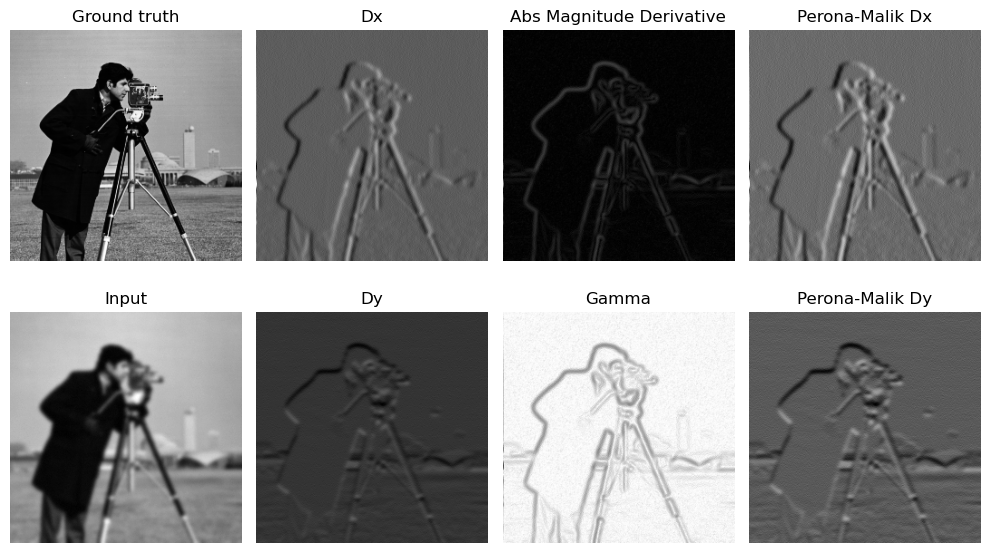

In [4]:
"""Visualise Perona-Malik regularisation"""

Dx = dx_operator(g, conv_mode="periodic")
Dy = dy_operator(g, conv_mode="periodic")
flat_dims = np.prod(g.shape)
dx_g = Dx @ g.flatten()
dy_g = Dy @ g.flatten()
abs_derivative = np.sqrt(np.square(dx_g) + np.square(dy_g))
threshold = 0.5 * np.max(abs_derivative)
gamma = np.exp(-abs_derivative / threshold)
gamma_diag_hat = np.sqrt(sp.diags(gamma.ravel()))
pm = sp.vstack([gamma_diag_hat @ Dx, gamma_diag_hat @ Dy])
pm_g = pm @ g.flatten()

fig, axs = plt.subplots(2, 4, figsize=(10, 6))

axs[0, 0].imshow(f, cmap="gray")
axs[0, 0].set_title("Ground truth")
axs[0, 0].axis("off")
axs[0, 1].imshow(dx_g.reshape(g.shape), cmap="gray")
axs[0, 1].set_title("Dx")
axs[0, 1].axis("off")
axs[0, 2].imshow(abs_derivative.reshape(g.shape), cmap="gray")
axs[0, 2].set_title("Abs Magnitude Derivative")
axs[0, 2].axis("off")
axs[0, 3].imshow(pm_g[0:flat_dims].reshape(g.shape), cmap="gray")
axs[0, 3].set_title("Perona-Malik Dx")
axs[0, 3].axis("off")
axs[1, 0].imshow(g, cmap="gray")
axs[1, 0].set_title("Input")
axs[1, 0].axis("off")
axs[1, 1].imshow(dy_g.reshape(g.shape), cmap='gray')
axs[1, 1].set_title("Dy")
axs[1, 1].axis("off")
axs[1, 2].imshow(gamma.reshape(g.shape), cmap="gray")
axs[1, 2].set_title("Gamma")
axs[1, 2].axis("off")
axs[1, 3].imshow(pm_g[flat_dims:].reshape(g.shape), cmap="gray")
axs[1, 3].set_title("Perona-Malik Dy")
axs[1, 3].axis("off")

plt.tight_layout()
plt.show()

In [5]:
"""Set up parameters"""

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

[INFO] 2024-11-24 21:23:10 | Alpha 1e-08: DP -5.301453537463271e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:10 | Alpha 1e-07: DP -5.301453122526133e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:10 | Alpha 1e-06: DP -5.301412004665331e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:11 | Alpha 1e-05: DP -5.297649019529926e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:11 | Alpha 0.0001: DP -5.112616386461787e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:11 | Alpha 0.001: DP -3.5086593425278287e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:11 | Alpha 0.01: DP 2.9470144283323855e-05 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:11 | Alpha 0.1: DP 0.002302447299627813 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:11 | Alpha 1.0: DP 0.06643872899254964 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:11 | Alpha 1

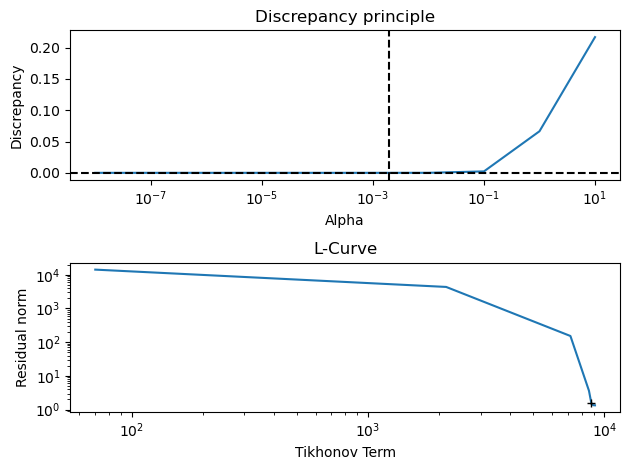

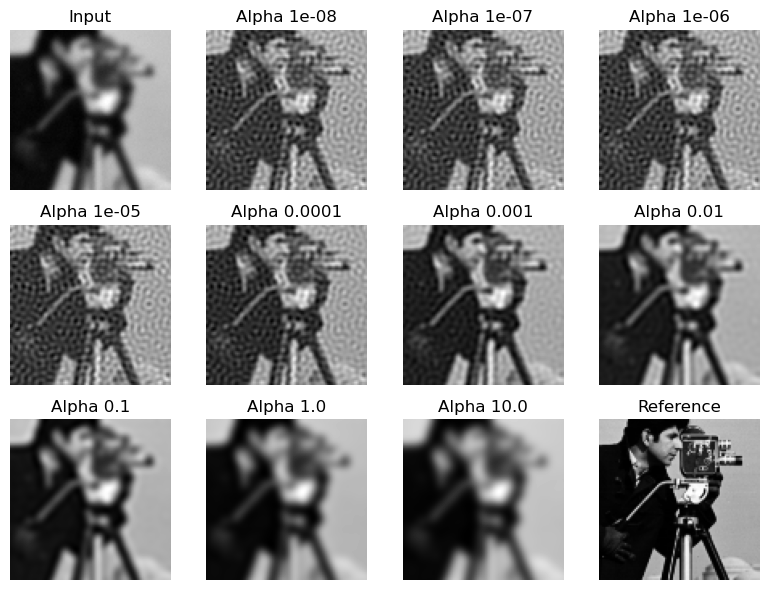

Optimal alpha: 0.0019575221236344943
DP: -1.942653551064259e-06, MSE: 0.003250429552076076


In [6]:
"""Optimise for TK0"""

lsqr_tk0 = StandardTuner(
    g=g,
    kernel=kernel,
    solver=LSQRSolver,
    noise_variance=noise_variance,
    f=f,
)
lsqr_tk0.parameter_sweep(alphas=alphas, L=identity_operator(f), save_imgs=True)
lsqr_tk0.display_metrics()
lsqr_tk0.display_sample()
print(f"Optimal alpha: {lsqr_tk0.optimal_alpha}")
print(f"DP: {lsqr_tk0.optimal_metrics['discrepancy']}, MSE: {lsqr_tk0.optimal_metrics['MSE']}")

[INFO] 2024-11-24 21:23:13 | Alpha 1e-08: DP -5.301447865260353e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:14 | Alpha 1e-07: DP -5.301395337648095e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:14 | Alpha 1e-06: DP -5.300730698339661e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:15 | Alpha 1e-05: DP -5.282861317711088e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:15 | Alpha 0.0001: DP -4.884601507985015e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:15 | Alpha 0.001: DP -3.4195805316200146e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:16 | Alpha 0.01: DP 1.975785768846881e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:16 | Alpha 0.1: DP 4.564871643253865e-05 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:16 | Alpha 1.0: DP 0.0004088665667588542 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:16 | Alpha

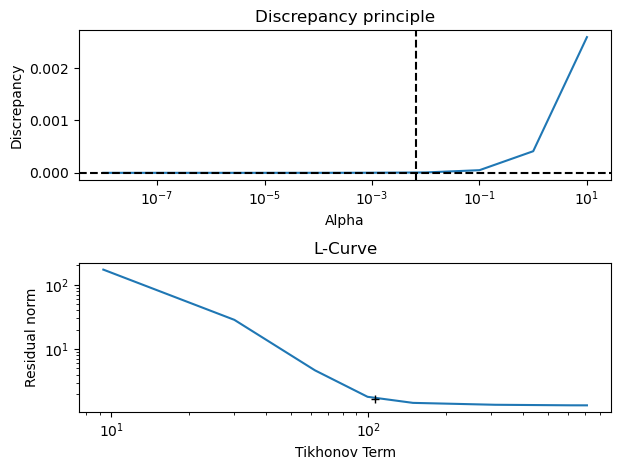

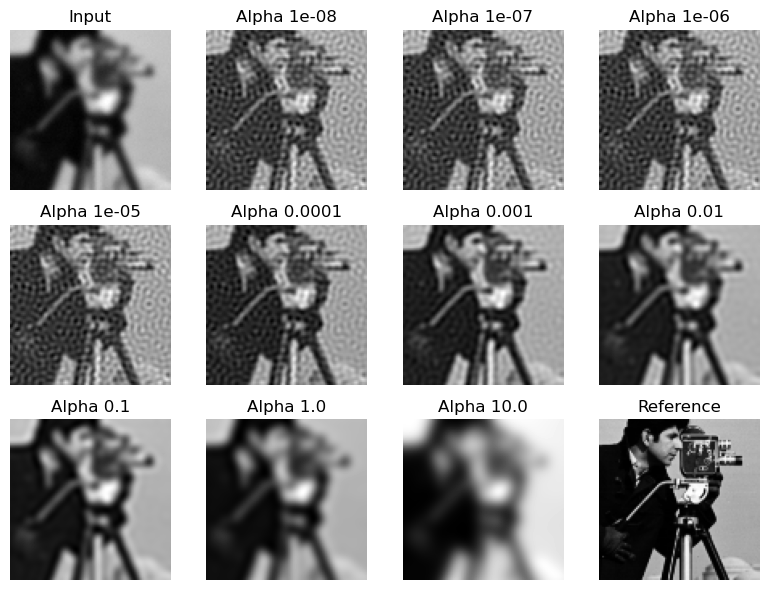

Optimal alpha: 0.00670419561354284
DP: 1.9852675200522825e-07, MSE: 0.0036124417484955725


In [7]:
"""Optimise for TK1"""

lsqr_tk1 = StandardTuner(
    g=g,
    kernel=kernel,
    solver=LSQRSolver,
    noise_variance=noise_variance,
    f=f,
)
lsqr_tk1.parameter_sweep(
    alphas=alphas,
    L=derivative_operator(f, conv_mode="periodic"),
    save_imgs=True
)
lsqr_tk1.display_metrics()
lsqr_tk1.display_sample()
print(f"Optimal alpha: {lsqr_tk1.optimal_alpha}")
print(f"DP: {lsqr_tk1.optimal_metrics['discrepancy']}, MSE: {lsqr_tk1.optimal_metrics['MSE']}")

[INFO] 2024-11-24 21:23:18 | Alpha 1e-08: DP -5.30144822556562e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:18 | Alpha 1e-07: DP -5.301399275680304e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:19 | Alpha 1e-06: DP -5.300802736143545e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:19 | Alpha 1e-05: DP -5.286142609672816e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:19 | Alpha 0.0001: DP -4.956336876859197e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:20 | Alpha 0.001: DP -3.721387110448894e-06 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:20 | Alpha 0.01: DP -4.4124194719706044e-07 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:20 | Alpha 0.1: DP 2.3577914961170022e-05 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:20 | Alpha 1.0: DP 0.00024391734637215837 | evaluation.tuning-parameter_sweep:267
[INFO] 2024-11-24 21:23:20 | Alp

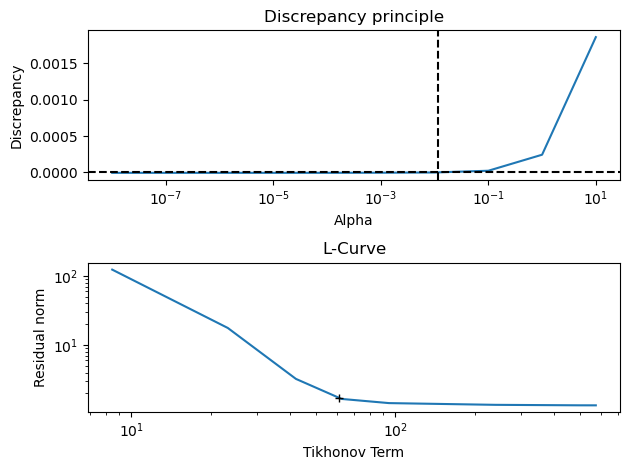

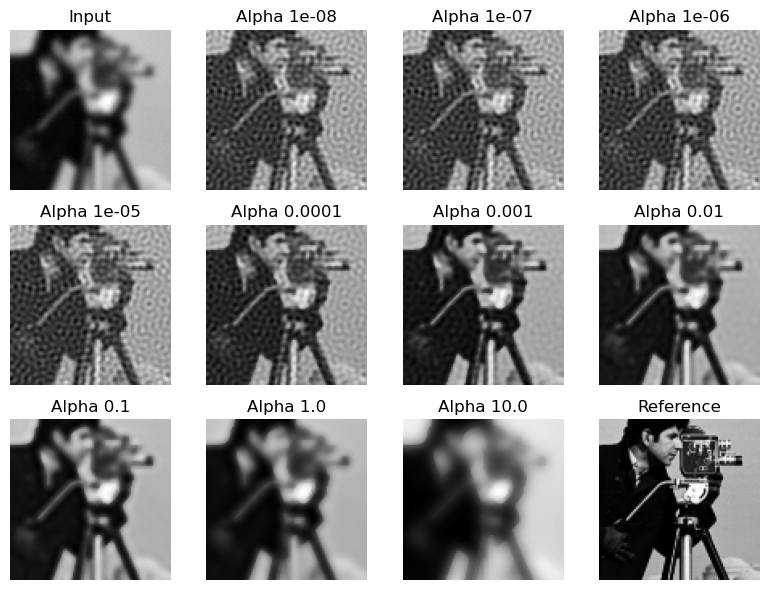

Optimal alpha: 0.011653337600450989
DP: 4.5322757981660874e-08, MSE: 0.0027437650777790857


In [8]:
"""Optimise and generate example images Perona-Malik"""

lsqr_pm = StandardTuner(
    g=g,
    kernel=kernel,
    solver=LSQRSolver,
    noise_variance=noise_variance,
    f=f,
)
lsqr_pm.parameter_sweep(
    alphas=alphas,
    L=perona_malik_operator(f, conv_mode="periodic"),
    save_imgs=True
)
lsqr_pm.display_metrics()
lsqr_pm.display_sample()
print(f"Optimal alpha: {lsqr_pm.optimal_alpha}")
print(f"DP: {lsqr_pm.optimal_metrics['discrepancy']}, MSE: {lsqr_pm.optimal_metrics['MSE']}")

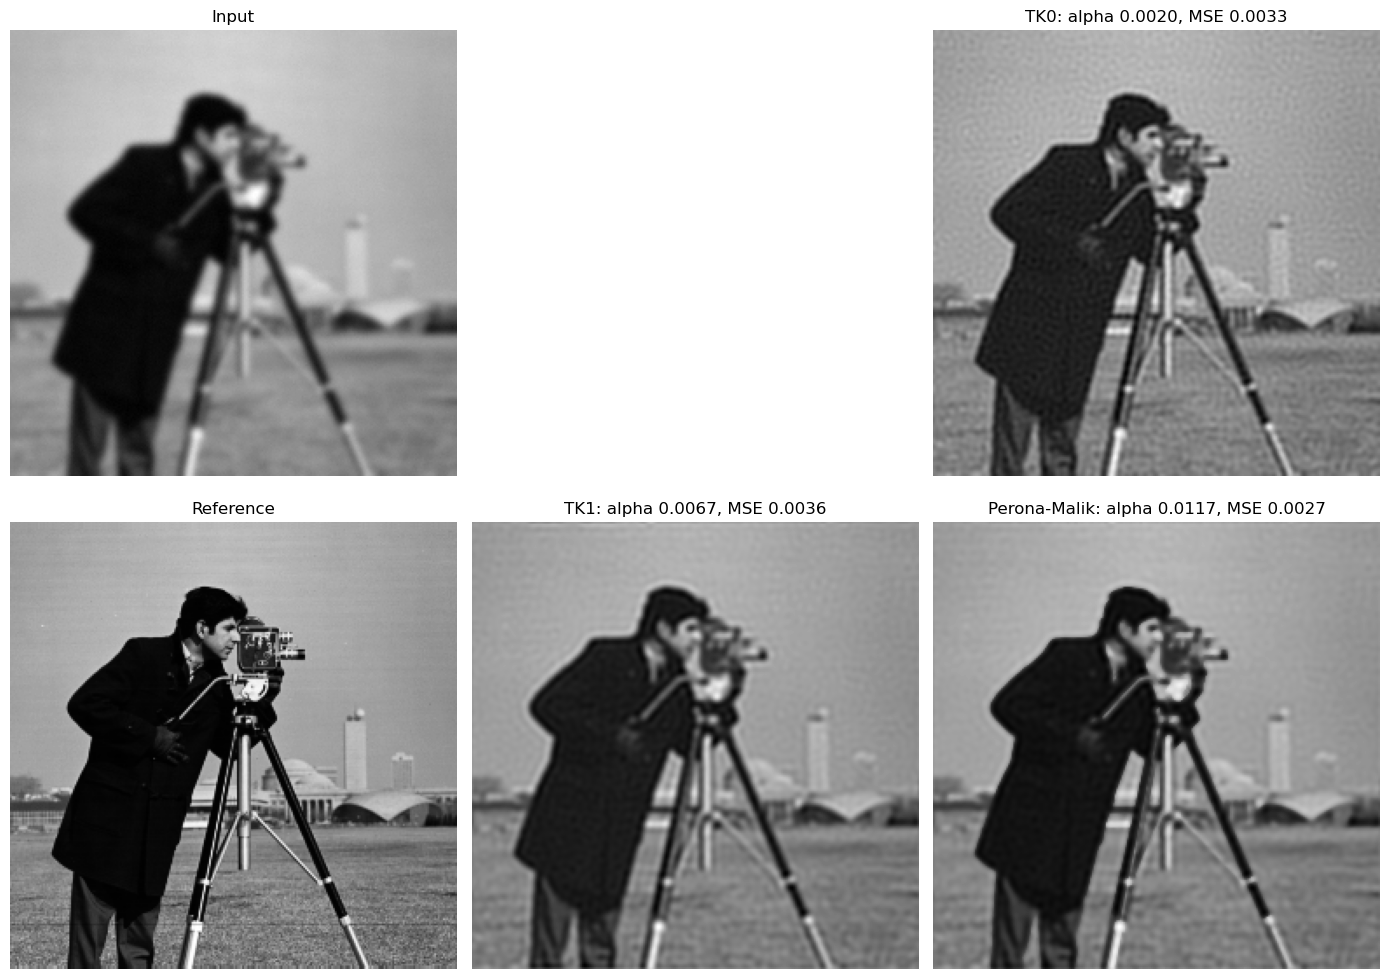

In [9]:
"""Compare regularisation techniques"""

_, axs = plt.subplots(2, 3, figsize=(14, 10))

axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[0, 1].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 2].imshow(lsqr_tk0._optimal_f_hat, cmap="gray")
axs[0, 2].set_title(f"TK0: alpha {lsqr_tk0.optimal_alpha:.4f}, MSE {lsqr_tk0.optimal_metrics['MSE']:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_tk1._optimal_f_hat, cmap="gray")
axs[1, 1].set_title(f"TK1: alpha {lsqr_tk1.optimal_alpha:.4f}, MSE {lsqr_tk1.optimal_metrics['MSE']:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm._optimal_f_hat, cmap="gray")
axs[1, 2].set_title(f"Perona-Malik: alpha {lsqr_pm.optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

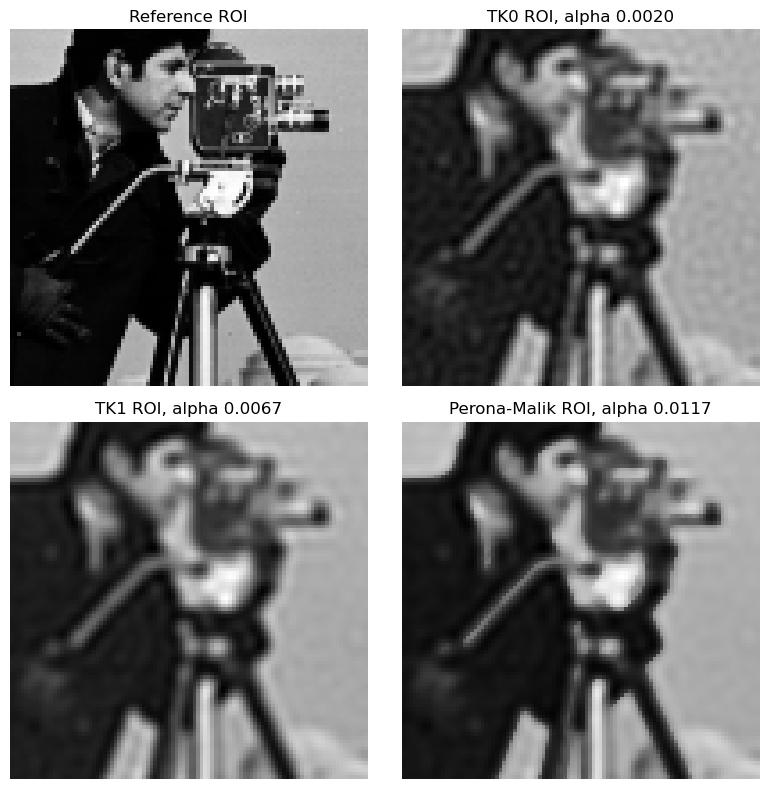

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(f[50:150, 80:180], cmap="gray")
axs[0, 0].set_title("Reference ROI")
axs[0, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0._optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 1].set_title(f"TK0 ROI, alpha {lsqr_tk0._optimal_alpha:.4f}")
axs[0, 1].axis("off")
axs[1, 0].imshow(lsqr_tk1._optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 0].set_title(f"TK1 ROI, alpha {lsqr_tk1._optimal_alpha:.4f}")
axs[1, 0].axis("off")
axs[1, 1].imshow(lsqr_pm._optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 1].set_title(f"Perona-Malik ROI, alpha {lsqr_pm._optimal_alpha:.4f}")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

[WARNING] 2024-11-24 21:24:43 | Alpha 1e-08: Maximum iterations reached, DP -8.196583902384364e-06 | evaluation.tuning-parameter_sweep:374
[WARNING] 2024-11-24 21:26:04 | Alpha 1e-07: Maximum iterations reached, DP -8.105031569000897e-06 | evaluation.tuning-parameter_sweep:374
[INFO] 2024-11-24 21:27:02 | Alpha 1e-06: DP -7.386834921826043e-06, iterations 72 | evaluation.tuning-parameter_sweep:378
[INFO] 2024-11-24 21:27:28 | Alpha 1e-05: DP -6.270872100376841e-06, iterations 32 | evaluation.tuning-parameter_sweep:378
[INFO] 2024-11-24 21:27:37 | Alpha 0.0001: DP -5.06854421959809e-06, iterations 12 | evaluation.tuning-parameter_sweep:378
[INFO] 2024-11-24 21:27:48 | Alpha 0.001: DP -3.6743131330938993e-06, iterations 15 | evaluation.tuning-parameter_sweep:378
[INFO] 2024-11-24 21:28:09 | Alpha 0.01: DP 5.145925143093134e-08, iterations 38 | evaluation.tuning-parameter_sweep:378
[INFO] 2024-11-24 21:28:22 | Alpha 0.1: DP 2.8327083897962655e-05, iterations 24 | evaluation.tuning-paramet

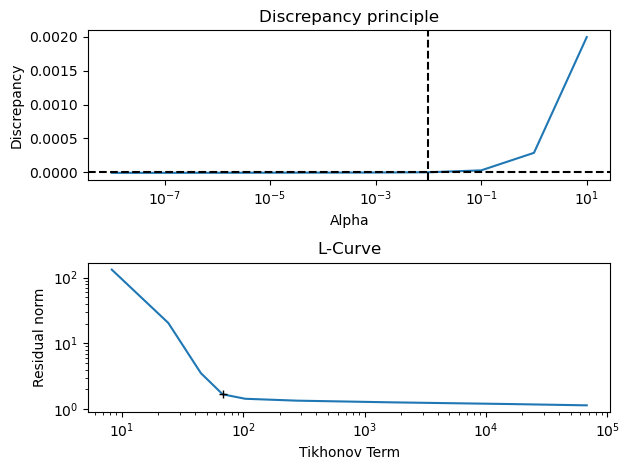

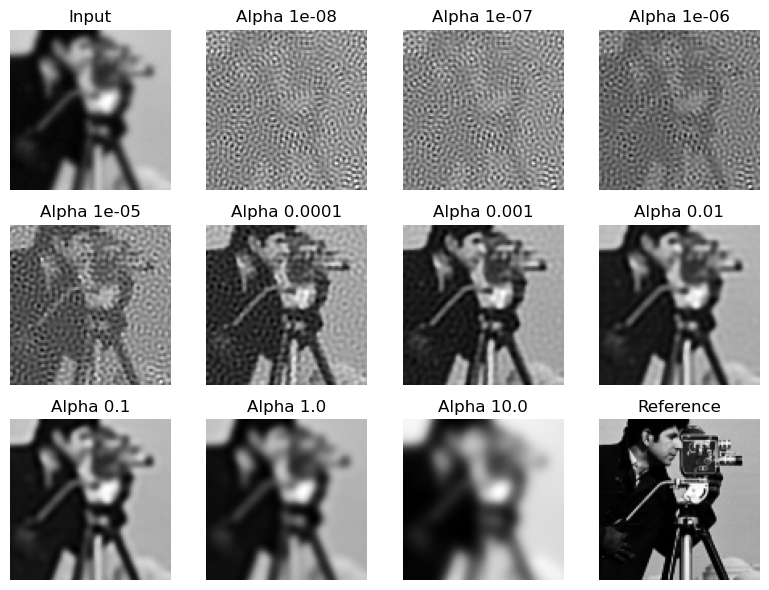

Optimal alpha: 0.011653337600450989
DP: 4.5322757981660874e-08, MSE: 0.0027437650777790857


In [11]:
"""Generate example images using iterative Perona-Malik"""

lsqr_pm_iter = IterativeTuner(
    g=g,
    kernel=kernel,
    solver=LSQRSolver,
    noise_variance=noise_variance,
    f=f,
)
lsqr_pm_iter.parameter_sweep(
    alphas=alphas,
    L=perona_malik_operator,
    save_imgs=True
)
lsqr_pm_iter.display_metrics()
lsqr_pm_iter.display_sample()
print(f"Optimal alpha: {lsqr_pm.optimal_alpha}")
print(f"DP: {lsqr_pm.optimal_metrics['discrepancy']}, MSE: {lsqr_pm.optimal_metrics['MSE']}")

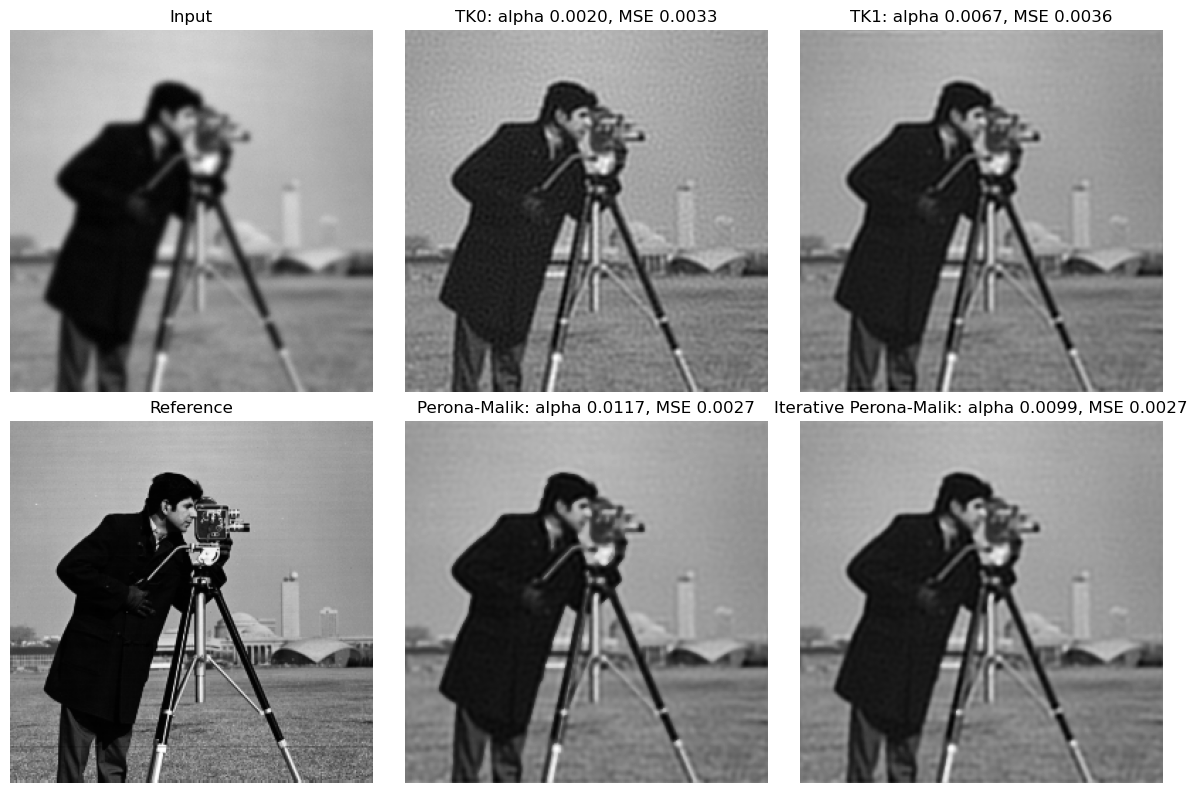

In [12]:
"""Compare regularisation techniques"""

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0._optimal_f_hat, cmap="gray")
axs[0, 1].set_title(f"TK0: alpha {lsqr_tk0.optimal_alpha:.4f}, MSE {lsqr_tk0.optimal_metrics['MSE']:.4f}")
axs[0, 1].axis("off")
axs[0, 2].imshow(lsqr_tk1._optimal_f_hat, cmap="gray")
axs[0, 2].set_title(f"TK1: alpha {lsqr_tk1.optimal_alpha:.4f}, MSE {lsqr_tk1.optimal_metrics['MSE']:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_pm._optimal_f_hat, cmap="gray")
axs[1, 1].set_title(f"Perona-Malik: alpha {lsqr_pm.optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm_iter._optimal_f_hat, cmap="gray")
axs[1, 2].set_title(f"Iterative Perona-Malik: alpha {lsqr_pm_iter._optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

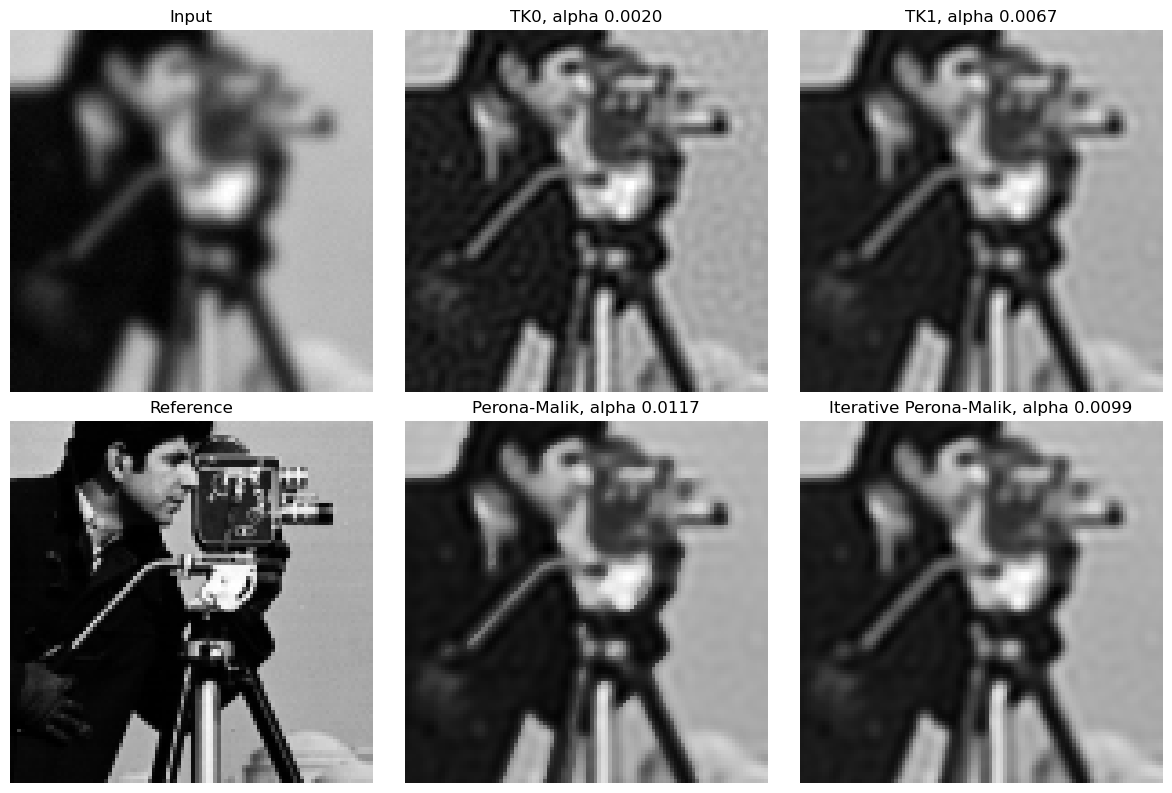

In [13]:
"""Compare regularisation techniques"""

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].imshow(g[50:150, 80:180], cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[1, 0].imshow(f[50:150, 80:180], cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0._optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 1].set_title(f"TK0, alpha {lsqr_tk0._optimal_alpha:.4f}")
axs[0, 1].axis("off")
axs[0, 2].imshow(lsqr_tk1._optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 2].set_title(f"TK1, alpha {lsqr_tk1._optimal_alpha:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_pm._optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 1].set_title(f"Perona-Malik, alpha {lsqr_pm._optimal_alpha:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm_iter._optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 2].set_title(f"Iterative Perona-Malik, alpha {lsqr_pm_iter._optimal_alpha:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [14]:
print(f"TK0: optimal alpha {lsqr_tk0.optimal_alpha:.4f}")
print(lsqr_tk0.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"TK1: optimal alpha {lsqr_tk1.optimal_alpha:.4f}")
print(lsqr_tk1.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"Perona-Malik: optimal alpha {lsqr_pm.optimal_alpha:.4f}")
print(lsqr_pm.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"Iterative Perona-Malik: optimal alpha {lsqr_pm_iter.optimal_alpha:.4f}")
print(lsqr_pm_iter.optimal_metrics[["MSE", "pSNR", "SSIM"]])

TK0: optimal alpha 0.0020
MSE       0.00325
pSNR    24.880592
SSIM     0.733295
Name: optimal, dtype: object
TK1: optimal alpha 0.0067
MSE      0.003612
pSNR    24.421991
SSIM     0.783039
Name: optimal, dtype: object
Perona-Malik: optimal alpha 0.0117
MSE      0.002744
pSNR    25.616531
SSIM     0.814681
Name: optimal, dtype: object
Iterative Perona-Malik: optimal alpha 0.0099
MSE     0.003405
pSNR    24.67883
SSIM    0.796726
Name: optimal, dtype: object
